In [ ]:
# !unzip "/content/drive/Shareddrives/FYP - knk/Datasets/WELFake/sementic+sentiment_welfake.zip" -d "/content/drive/Shareddrives/FYP - knk/Datasets/WELFake"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# import Lib

In [ ]:
import torch
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_fscore_support,confusion_matrix
from sklearn.svm import SVC
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

#def func

In [ ]:
def compute_metrics(pred,ground_labels):
    labels_all = ground_labels
    preds_all = list(pred)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels_all, preds_all)
    acc = accuracy_score(labels_all, preds_all)
    confusion_mat = confusion_matrix(labels_all, preds_all)
    # tn, fp, fn, tp = confusiton_mat.ravel()
    out_dict = {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusiton_mat': confusion_mat
    }
    return out_dict

# read data

In [ ]:
df=pd.read_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Kirishnni Emotion Extraction/Results/CovidCodeLab/CovidCodeLab_predictions_emotions.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           10697 non-null  int64  
 1   split                10697 non-null  object 
 2   text                 10697 non-null  object 
 3   id                   10697 non-null  object 
 4   label                10697 non-null  object 
 5   index                10697 non-null  int64  
 6   emotion_score_dict   10697 non-null  object 
 7   highest_eight_label  10697 non-null  object 
 8   anger                10697 non-null  float64
 9   anticipation         10697 non-null  float64
 10  disgust              10697 non-null  float64
 11  fear                 10697 non-null  float64
 12  joy                  10697 non-null  float64
 13  sadness              10697 non-null  float64
 14  surprise             10697 non-null  float64
 15  trust                10697 non-null 

In [ ]:
df.head()

,Unnamed: 0,label,text,id,source,index,emotion_score_dict,highest_eight_label,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,0,Fake,did miley cyrus and liam hemsworth secretly ge...,gossipcop-2493749932,gossipcop,0,"{'sadness': 0.098, 'surprise': 0.104, 'fear': ...",joy,0.273,0.991,0.184,0.107,1.147,0.098,0.104,0.402
1,1,Fake,paris jackson cara delevingne enjoy night out ...,gossipcop-4580247171,gossipcop,1,"{'anticipation': 0.0, 'sadness': 0.0, 'fear': ...",joy,0.102,0.000,0.059,0.040,2.856,0.000,0.082,0.336
2,2,Fake,celebrities join tax march in protest of donal...,gossipcop-941805037,gossipcop,2,"{'disgust': 0.061, 'sadness': 0.095, 'joy': 0....",anger,1.631,0.453,0.061,0.523,0.343,0.095,0.610,0.567
3,3,Fake,cindy crawford s daughter kaia gerber wears a ...,gossipcop-2547891536,gossipcop,3,"{'anticipation': 0.055, 'sadness': 0.118, 'fea...",joy,0.406,0.055,0.161,0.135,1.040,0.118,0.146,0.344
4,4,Fake,full list of oscar nominations variety,gossipcop-5476631226,gossipcop,4,"{'surprise': 0.0, 'disgust': 0.148, 'anger': 0...",trust,0.210,0.945,0.148,0.354,0.898,0.221,0.000,2.650


# Processing data

In [ ]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [ ]:
data = df

In [ ]:
data.describe()

,index,label,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
count,62602.000000,62602.000000,62602.000000,62602.000000,62602.000000,62602.000000,62602.000000,62602.000000,62602.000000,62602.000000
mean,31300.500000,0.444586,0.045037,0.032654,0.013391,0.028234,0.027337,0.015269,0.021921,0.028113
std,18071.785113,0.496924,0.162769,0.156008,0.062199,0.128207,0.103200,0.056670,0.076117,0.119551
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15650.250000,0.000000,0.008000,0.006000,0.002000,0.006000,0.005000,0.003000,0.007000,0.003000
50%,31300.500000,0.000000,0.017000,0.012000,0.004000,0.012000,0.010000,0.007000,0.011000,0.009000
75%,46950.750000,1.000000,0.036000,0.025000,0.010000,0.022000,0.020000,0.012000,0.018000,0.022000
max,62601.000000,1.000000,14.008000,23.945000,6.682000,14.061000,5.557000,4.366000,8.020000,15.232000


# Visualize

In [ ]:
emotion = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

In [ ]:
import ast

def change_string_dict(emotion_str):
  res = ast.literal_eval(emotion_str)
  return res

df['cum_emotion_score_dict'] = df['cum_emotion_score_dict'].apply(change_string_dict)

eight_label = df['cum_emotion_score_dict'].to_list()

df["anger"]=[i["anger"] for i in eight_label]
df["anticipation"]=[i["anticipation"] for i in eight_label]
df["disgust"]=[i["disgust"] for i in eight_label]
df["fear"]=[i["fear"] for i in eight_label]
df["joy"]=[i["joy"] for i in eight_label]
df["sadness"]=[i["sadness"] for i in eight_label]
df["surprise"]=[i["surprise"] for i in eight_label]
df["trust"]=[i["trust"] for i in eight_label]

In [ ]:
X=data[emotion]
Y=data.label

In [ ]:
from sklearn import preprocessing
import numpy as np

min_max_scaler = preprocessing.MinMaxScaler()
data[emotion] = min_max_scaler.fit_transform(data[emotion])

In [ ]:
data[emotion]

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,5.717,1.485,3.319,7.823,2.374,13.068,2.512,2.976
1,2.039,1.657,0.419,1.233,1.072,1.971,0.173,2.708
2,9.329,11.821,2.801,7.192,7.833,14.833,3.088,15.894
3,0.923,0.373,0.067,0.306,0.291,0.677,0.141,0.673
4,35.592,18.926,9.702,22.279,22.098,20.775,5.084,45.565
...,...,...,...,...,...,...,...,...
1995,0.306,0.870,0.066,0.232,0.189,0.138,0.128,0.547
1996,5.563,3.801,1.189,6.839,2.460,4.951,1.224,10.129
1997,11.547,1.737,1.789,5.067,2.493,3.239,0.910,4.447
1998,1.575,3.075,0.468,1.937,3.074,0.959,0.698,3.863


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39100 entries, 0 to 39099
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   text                 39100 non-null  object 
 1   id                   39100 non-null  int64  
 2   label                39100 non-null  int64  
 3   highest_eight_label  39100 non-null  object 
 4   anger                39100 non-null  float64
 5   anticipation         39100 non-null  float64
 6   disgust              39100 non-null  float64
 7   fear                 39100 non-null  float64
 8   joy                  39100 non-null  float64
 9   sadness              39100 non-null  float64
 10  surprise             39100 non-null  float64
 11  trust                39100 non-null  float64
dtypes: float64(8), int64(2), object(2)
memory usage: 3.6+ MB


In [ ]:
data.head()

,text,id,label,highest_eight_label,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,as u s budget fight looms republicans flip the...,0,0,anger,0.009009,0.002412,0.004,0.002039,0.005952,0.002427,0.0,0.002582
1,u s military to accept transgender recruits on...,1,0,trust,0.004505,0.002894,0.004,0.002548,0.002976,0.019417,0.0,0.005164
2,senior u s republican senator let mr mueller d...,2,0,trust,0.002252,0.003859,0.000,0.002548,0.013393,0.002427,0.0,0.010586
3,fbi russia probe helped by australian diplomat...,3,0,trust,0.014264,0.001447,0.004,0.005097,0.017857,0.014563,0.0,0.005680
4,trump wants postal service to charge much more...,4,0,anger,0.010511,0.000000,0.024,0.001529,0.004464,0.009709,0.0,0.000516


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


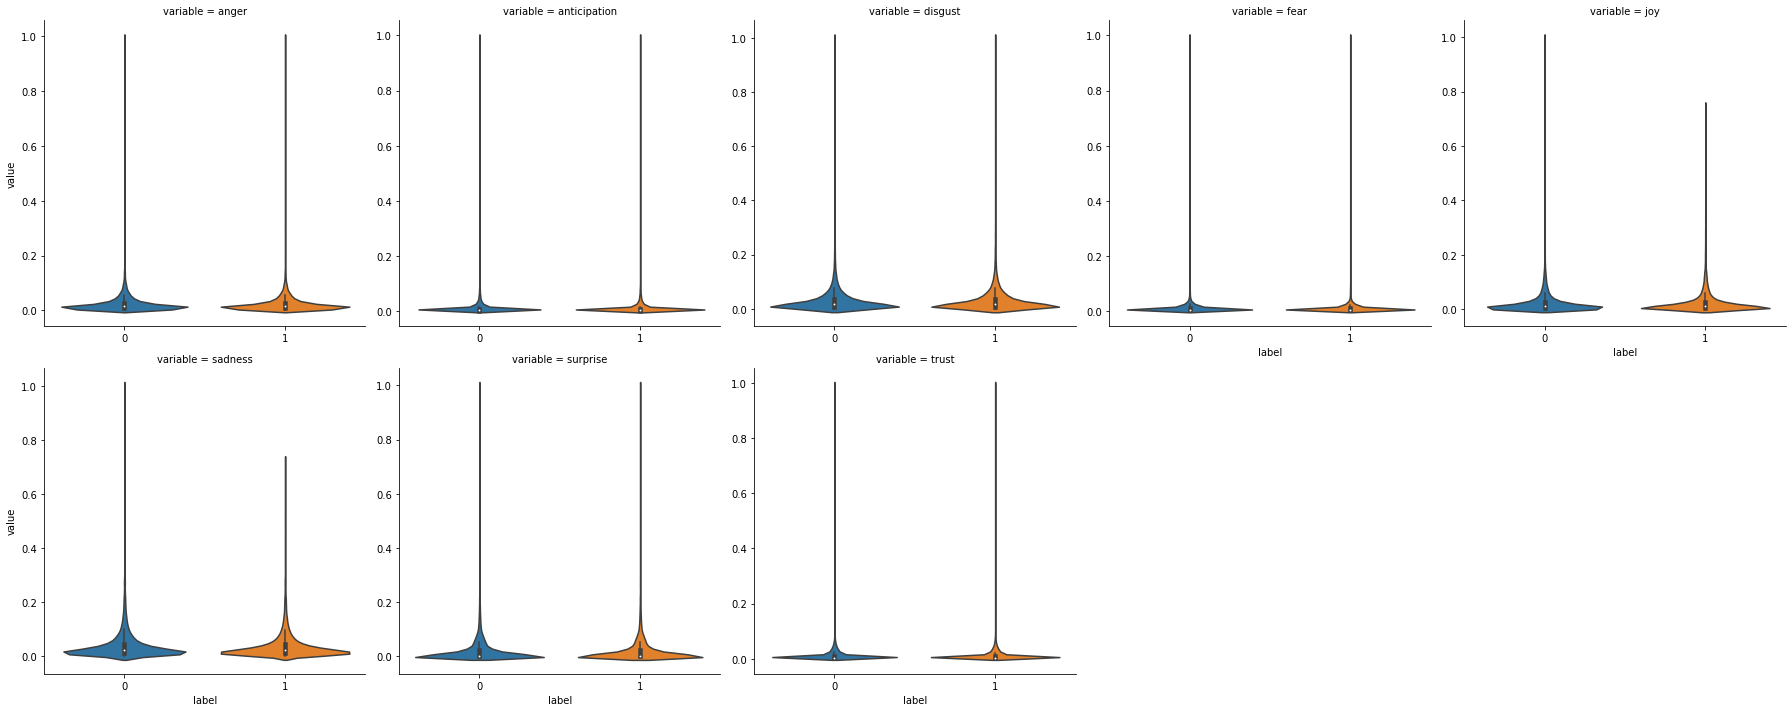

In [ ]:
f = pd.melt( data[emotion+["label"]], id_vars='label', value_vars=emotion)

g = sns.catplot(x="label" , y="value",
                col="variable",col_wrap=5,
                data=f, kind="violin",sharey=False,sharex=False);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e56c4cfd0>,
      dtype=object)

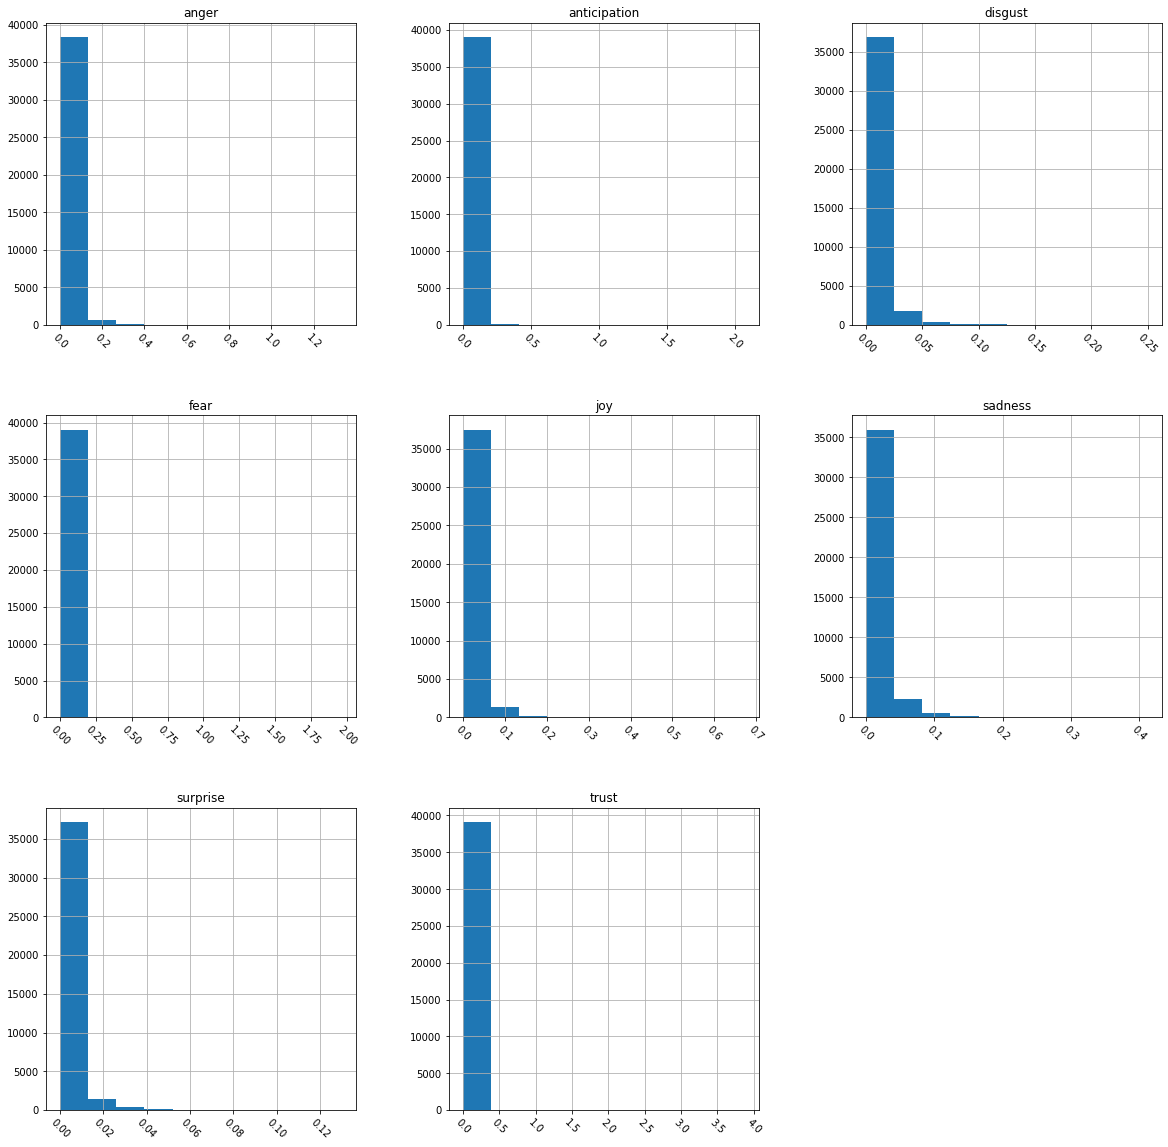

In [ ]:
X.hist(figsize=(20,20), xrot=-45 ,)

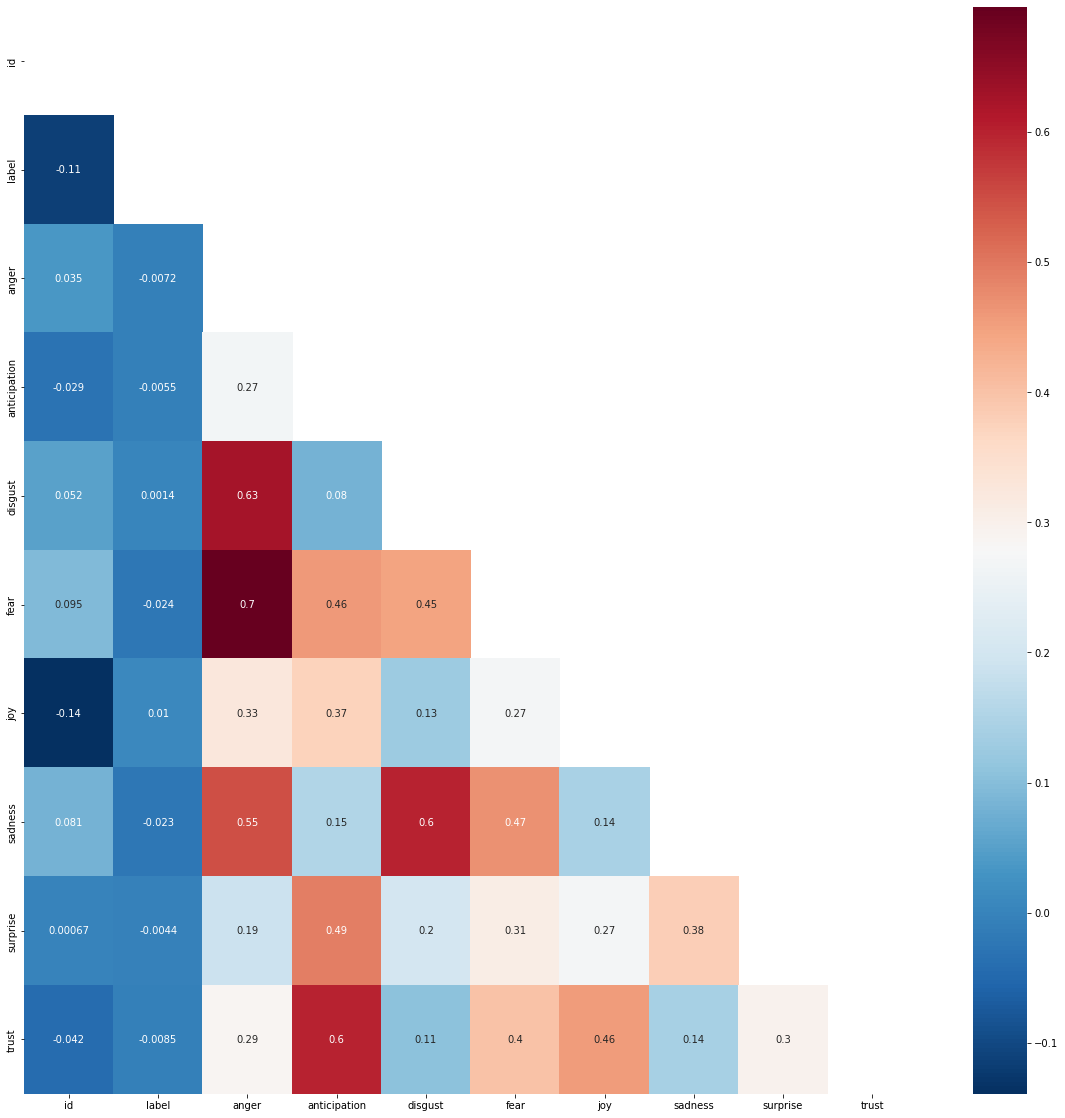

In [ ]:
import seaborn as sns
# mask out upper triangle
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask
            )

# Feature analysis

In [ ]:
# # Encoding above ordinal data using OrdinalEncoder
# from sklearn.preprocessing import OrdinalEncoder

# ordinalencoder = OrdinalEncoder()
# data['highest_eight_label'] = ordinalencoder.fit_transform(data[['highest_eight_label']])

# data.info()

In [ ]:
# data['highest_eight_label'].unique()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   split                10697 non-null  object 
 1   text                 10697 non-null  object 
 2   id                   10697 non-null  object 
 3   label                10697 non-null  object 
 4   index                10697 non-null  int64  
 5   emotion_score_dict   10697 non-null  object 
 6   highest_eight_label  10697 non-null  object 
 7   anger                10697 non-null  float64
 8   anticipation         10697 non-null  float64
 9   disgust              10697 non-null  float64
 10  fear                 10697 non-null  float64
 11  joy                  10697 non-null  float64
 12  sadness              10697 non-null  float64
 13  surprise             10697 non-null  float64
 14  trust                10697 non-null  float64
dtypes: float64(8), int64(1), object(6)
m

In [ ]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10697 entries, 0 to 10696
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   split                10697 non-null  object 
 1   text                 10697 non-null  object 
 2   id                   10697 non-null  object 
 3   label                10697 non-null  object 
 4   index                10697 non-null  int64  
 5   emotion_score_dict   10697 non-null  object 
 6   highest_eight_label  10697 non-null  object 
 7   anger                10697 non-null  float64
 8   anticipation         10697 non-null  float64
 9   disgust              10697 non-null  float64
 10  fear                 10697 non-null  float64
 11  joy                  10697 non-null  float64
 12  sadness              10697 non-null  float64
 13  surprise             10697 non-null  float64
 14  trust                10697 non-null  float64
dtypes: float64(8), int64(1), object(6)
m

In [ ]:
emotion = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
X=data[emotion]
Y=data.label

In [ ]:
X.head()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,0.040,0.000,0.008,0.007,0.003,0.002,0.003,0.002
1,0.041,0.000,0.006,0.014,0.012,0.022,0.008,0.002
2,0.022,0.001,0.003,0.005,0.006,0.009,0.003,0.001
3,0.022,0.004,0.002,0.009,0.026,0.002,0.008,0.002
4,0.022,0.011,0.002,0.005,0.012,0.009,0.000,0.017


In [ ]:
Y

0       0
1       0
2       0
3       0
4       0
       ..
1995    1
1996    1
1997    1
1998    1
1999    1
Name: label, Length: 2000, dtype: int64

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinalencoder = OrdinalEncoder()
X['highest_eight_label'] = ordinalencoder.fit_transform(X[['highest_eight_label']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   anger         10697 non-null  float64
 1   anticipation  10697 non-null  float64
 2   disgust       10697 non-null  float64
 3   fear          10697 non-null  float64
 4   joy           10697 non-null  float64
 5   sadness       10697 non-null  float64
 6   surprise      10697 non-null  float64
 7   trust         10697 non-null  float64
dtypes: float64(8)
memory usage: 668.7 KB


In [ ]:
X.head()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,5.717,1.485,3.319,7.823,2.374,13.068,2.512,2.976
1,2.039,1.657,0.419,1.233,1.072,1.971,0.173,2.708
2,9.329,11.821,2.801,7.192,7.833,14.833,3.088,15.894
3,0.923,0.373,0.067,0.306,0.291,0.677,0.141,0.673
4,35.592,18.926,9.702,22.279,22.098,20.775,5.084,45.565


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=142,stratify=Y)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  "X does not have valid feature names, but"


Optimal number of features : 8


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


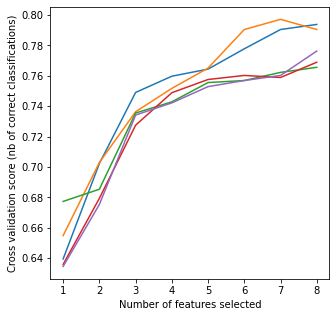

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100,max_features='auto',random_state=0,max_depth=14,class_weight='balanced')
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
# rfecv.fit(X, Y)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
rfecv.grid_scores_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


array([[0.63951936, 0.65487316, 0.67735471, 0.63593854, 0.63460254],
       [0.70226969, 0.70293725, 0.68537074, 0.67935872, 0.6753507 ],
       [0.74899866, 0.73631509, 0.73547094, 0.72745491, 0.73413494],
       [0.75967957, 0.75166889, 0.74281897, 0.748831  , 0.74215097],
       [0.76435247, 0.76502003, 0.75551102, 0.75751503, 0.75283901],
       [0.7777036 , 0.79038718, 0.75684703, 0.76018704, 0.75684703],
       [0.79038718, 0.79706275, 0.76219105, 0.75885104, 0.76018704],
       [0.79372497, 0.79038718, 0.76553106, 0.76887108, 0.7762191 ]])

In [ ]:
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
print(X.columns.values[rfecv.support_])

['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']


In [ ]:
rfecv.estimator_

RandomForestClassifier(class_weight='balanced', max_depth=14, random_state=0)

In [ ]:
rfecv_features=list(X.columns.values[rfecv.support_])

In [ ]:
rfecv_features

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise',
 'trust']

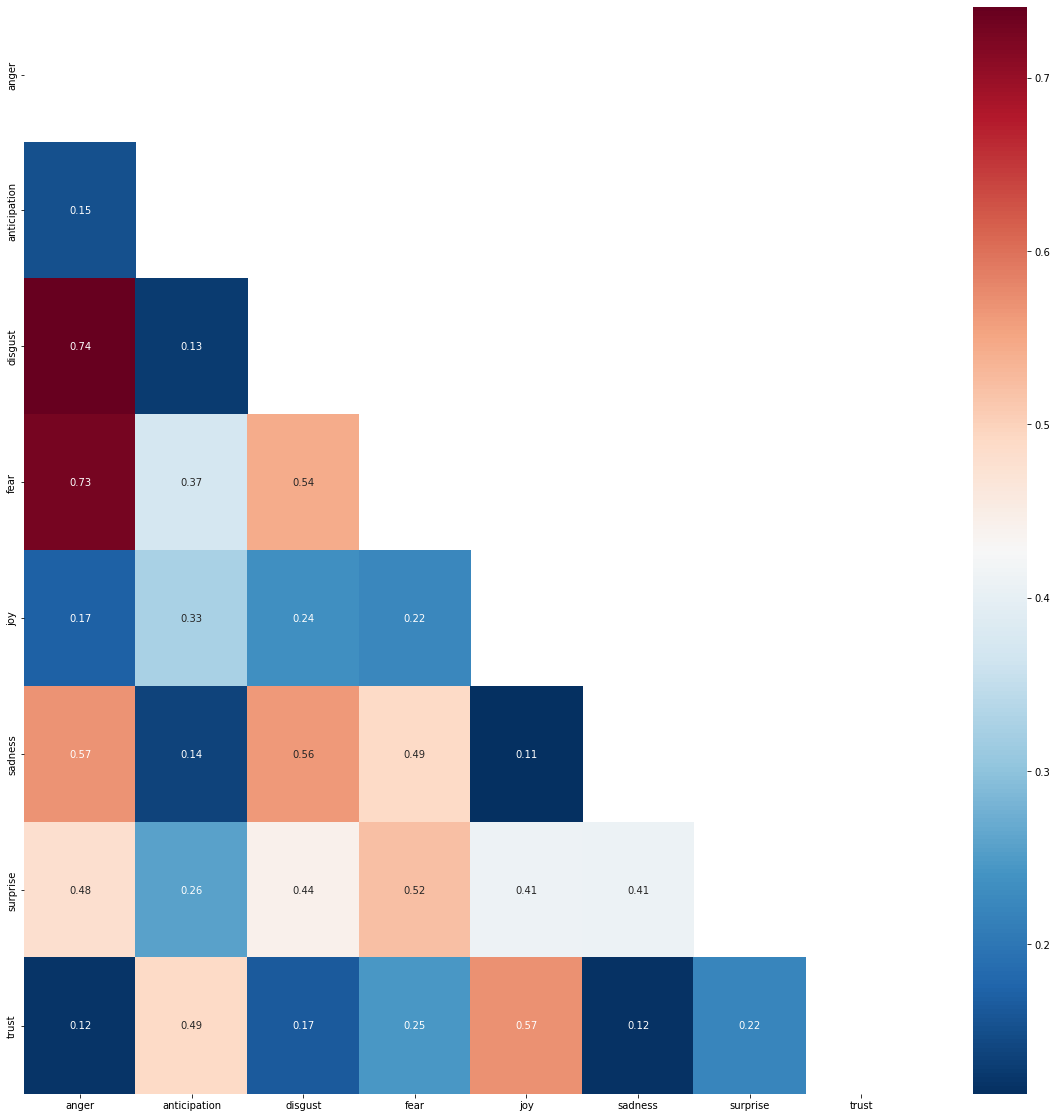

In [ ]:
# mask out upper triangle
mask = np.zeros_like(data[rfecv_features+["label"]].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,20))
sns.heatmap(data[rfecv_features+["label"]].corr(), 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask
            )

In [ ]:
emotion

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise',
 'trust']

In [ ]:
# X_val = df_test[emotion]
# y_val = df_test.label

In [ ]:
# from sklearn.preprocessing import OrdinalEncoder
# ordinalencoder = OrdinalEncoder()
# X_val['highest_eight_label'] = ordinalencoder.fit_transform(X_val[['highest_eight_label']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16307 entries, 13257 to 24330
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   anger                16307 non-null  float64
 1   anticipation         16307 non-null  float64
 2   disgust              16307 non-null  float64
 3   fear                 16307 non-null  float64
 4   joy                  16307 non-null  float64
 5   sadness              16307 non-null  float64
 6   surprise             16307 non-null  float64
 7   trust                16307 non-null  float64
 8   highest_eight_label  16307 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [ ]:
from sklearn import metrics
predicted_y = rfecv.predict(X_val)
gg=compute_metrics(predicted_y,y_val)
d=gg
# print(d['accuracy'])
tn, fp, fn, tp = d["confusiton_mat"].ravel()
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
0.771	0.787	0.765	0.793	0.768	0.790	0.779	1170	360	348	1332


In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=142,stratify=Y)

In [ ]:
X.head()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,highest_eight_label
0,0.370,0.223,0.178,0.094,0.255,0.207,0.000,1.786,7.0
1,0.166,0.206,0.000,0.084,0.178,0.144,0.048,0.184,1.0
2,0.152,0.085,0.043,0.036,0.059,0.108,0.000,1.291,7.0
3,0.000,0.741,0.050,0.105,0.268,0.159,0.075,1.438,7.0
4,0.157,0.780,0.097,0.071,0.535,0.421,0.054,0.550,1.0


# compare different models

In [ ]:
emotion

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise',
 'trust']

In [ ]:
X

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,0.016,0.002,0.015,0.016,0.003,0.032,0.007,0.000
1,0.017,0.013,0.002,0.012,0.012,0.004,0.000,0.017
2,0.003,0.014,0.001,0.003,0.006,0.000,0.002,0.006
3,0.068,0.037,0.000,0.046,0.037,0.031,0.016,0.093
4,0.024,0.001,0.002,0.017,0.001,0.007,0.001,0.000
...,...,...,...,...,...,...,...,...
1995,0.020,0.017,0.007,0.024,0.015,0.002,0.008,0.040
1996,0.010,0.004,0.005,0.013,0.001,0.030,0.004,0.001
1997,0.041,0.000,0.004,0.021,0.006,0.009,0.005,0.000
1998,0.014,0.029,0.002,0.013,0.027,0.003,0.000,0.031


In [ ]:
X_train

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
1050,0.065,0.096,0.007,0.074,0.084,0.023,0.012,0.114
1045,0.067,0.000,0.004,0.017,0.000,0.012,0.004,0.000
1105,0.003,0.002,0.002,0.005,0.003,0.002,0.002,0.010
294,0.085,0.040,0.010,0.039,0.018,0.097,0.014,0.047
695,0.044,0.190,0.000,0.034,0.061,0.003,0.000,0.084
...,...,...,...,...,...,...,...,...
1699,0.035,0.007,0.004,0.023,0.012,0.007,0.000,0.023
960,0.012,0.008,0.004,0.007,0.003,0.018,0.004,0.003
1910,0.010,0.004,0.001,0.004,0.009,0.003,0.001,0.047
1194,0.009,0.006,0.001,0.006,0.004,0.003,0.001,0.013


In [ ]:
# X_train = X
# y_train = Y
# X_val = df_test[emotion]
# y_val = df_test.label

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinalencoder = OrdinalEncoder()
X_val['highest_eight_label'] = ordinalencoder.fit_transform(X_val[['highest_eight_label']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [ ]:
classifiers=[['Logistic Regression :',LogisticRegression()],
       ['Decision Tree Classification :',DecisionTreeClassifier()],
       ['Gradient Boosting Classification :', GradientBoostingClassifier()],
       ['Ada Boosting Classification :',AdaBoostClassifier()],
       ['Extra Tree Classification :', ExtraTreesClassifier()],
       ['K-Neighbors Classification :',KNeighborsClassifier()],
       ['Support Vector Classification :',SVC()],
       ['Gaussian Naive Bayes :',GaussianNB()]]
cla_pred=[]

In [ ]:
# ~ 4-5 min run 
for name,model1 in classifiers:
    print("-----------"+name+"-------------")
    model1.fit(X_train,y_train)
    predicted_y = model1.predict(X_val)
    score=compute_metrics(predicted_y,y_val)
    cla_pred.append(score)

-----------Logistic Regression :-------------
-----------Decision Tree Classification :-------------
-----------Gradient Boosting Classification :-------------
-----------Ada Boosting Classification :-------------
-----------Extra Tree Classification :-------------
-----------K-Neighbors Classification :-------------
-----------Support Vector Classification :-------------
-----------Gaussian Naive Bayes :-------------


In [ ]:
Y.value_counts()

real    5599
fake    5098
Name: label, dtype: int64

In [ ]:
X

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,0.016,0.002,0.015,0.016,0.003,0.032,0.007,0.000
1,0.017,0.013,0.002,0.012,0.012,0.004,0.000,0.017
2,0.003,0.014,0.001,0.003,0.006,0.000,0.002,0.006
3,0.068,0.037,0.000,0.046,0.037,0.031,0.016,0.093
4,0.024,0.001,0.002,0.017,0.001,0.007,0.001,0.000
...,...,...,...,...,...,...,...,...
1995,0.020,0.017,0.007,0.024,0.015,0.002,0.008,0.040
1996,0.010,0.004,0.005,0.013,0.001,0.030,0.004,0.001
1997,0.041,0.000,0.004,0.021,0.006,0.009,0.005,0.000
1998,0.014,0.029,0.002,0.013,0.027,0.003,0.000,0.031


In [ ]:
# #Prining the evaluation matrix to the console
# print("Summary\n Class 0- True news \n Class 1 - False news\n")
# for i in range(len(classifiers)):
#   print("-----------"+classifiers[i][0]+"-------------")
#   d=cla_pred[i]
#   print ("{:}\t{:}\t{:}\t{:}".format('label','precision','recall',"f1-score"))
#   print ("{:}\t{:.3f}\t\t{:.3f}\t{:.3f}".format("0", d['precision'][0], d['recall'][0],d['f1'][0]))
#   print ("{:}\t{:.3f}\t\t{:.3f}\t{:.3f}".format("1", d['precision'][1], d['recall'][1],d['f1'][1]))
#   print("\n")
#   print ("{:<5} {:<15}".format("accuracy", d['accuracy']))
#   print("\n")
#   print("confusiton_mat")
#   tn, fp, fn, tp = cla_pred[i]["confusiton_mat"].ravel()
#   print ("{:<25} {:<10} {:<10}".format("Actual \Prediction", "0","1"))
#   print ("{:<25} {:<10} {:<10}".format("0", tn,fp))
#   print ("{:<25} {:<10} {:<10}".format("1", fn,tp))
#   print("\n")

In [ ]:
#Prining the evaluation matrix to the console
print("Summary\n Class 0- True news \n Class 1 - False news\n")
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
for i in range(len(classifiers)):
  # print("-----------"+classifiers[i][0]+"-------------")
  d=cla_pred[i]
  # print(d['accuracy'])
  tn, fp, fn, tp = cla_pred[i]["confusiton_mat"].ravel() #correct
  print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

Summary
 Class 0- True news 
 Class 1 - False news

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
0.775	0.685	0.573	0.848	0.658	0.758	0.717	876	654	255	1425
0.676	0.706	0.677	0.705	0.677	0.705	0.692	1036	494	496	1184
0.758	0.745	0.701	0.796	0.728	0.769	0.750	1072	458	343	1337
0.742	0.724	0.670	0.788	0.704	0.755	0.732	1025	505	356	1324
0.777	0.789	0.765	0.800	0.771	0.795	0.783	1171	359	336	1344
0.755	0.739	0.692	0.796	0.722	0.767	0.746	1059	471	343	1337
0.770	0.726	0.659	0.820	0.710	0.770	0.744	1009	521	302	1378
0.793	0.641	0.451	0.893	0.575	0.746	0.682	690	840	180	1500


In [ ]:
# -----------Logistic Regression :-------------
# -----------Decision Tree Classification :-------------
# -----------Gradient Boosting Classification :-------------
# -----------Ada Boosting Classification :-------------
# -----------Extra Tree Classification :-------------
# -----------K-Neighbors Classification :-------------
# -----------Support Vector Classification :-------------
# -----------Gaussian Naive Bayes :-------------

# SVG classifier

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
start = time.time()

svm_classifier = SVC(probability=True)
svm_classifier.fit(X,Y)

end = time.time()
process = round(end-start,2)
print("Support Vector Machine Classifier has fitted, this process took {} seconds".format(process))

# print(svm_classifier.score(X_val,y_val))

Support Vector Machine Classifier has fitted, this process took 14.11 seconds


In [ ]:
predicted_y = svm_classifier.predict(X_val)
print(predicted_y)

[1 1 1 ... 1 1 1]


In [ ]:
gg=compute_metrics(predicted_y,y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
gg

{'accuracy': 0.8358326756116812, 'confusiton_mat': array([[   0,  208],
        [   0, 1059]]), 'f1': array([0.       , 0.9105761]), 'precision': array([0.        , 0.83583268]), 'recall': array([0., 1.])}

In [ ]:
d=gg
print(d['accuracy'])
# tn, fp, fn, tp = d["confusiton_mat"].ravel()
# print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-f','prec-t', 'rec-f','rec-t','f1-f','f1-t','accu','tn', 'fp', 'fn', 'tp'))
# print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

0.8358326756116812


# K- Means

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
X

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,highest_eight_label,positive,negative
0,0.002318,0.000137,0.000334,0.000624,0.000000,0.001330,0.000515,0.000159,0.0,0.000158,0.001617
1,0.009142,0.005148,0.001505,0.003831,0.004816,0.005321,0.015448,0.015333,7.0,0.021263,0.009021
2,0.000515,0.000206,0.000167,0.000445,0.000000,0.000532,0.000000,0.000398,7.0,0.000421,0.000723
3,0.006052,0.000412,0.000502,0.004633,0.001267,0.002394,0.001545,0.000199,3.0,0.000632,0.005106
4,0.007340,0.000275,0.001505,0.001247,0.000507,0.003458,0.005149,0.000677,0.0,0.000632,0.006170
...,...,...,...,...,...,...,...,...,...,...,...
62597,0.003605,0.001304,0.001338,0.001693,0.000760,0.006385,0.004119,0.001075,0.0,0.002105,0.004723
62598,0.000773,0.000549,0.000334,0.000445,0.000507,0.000532,0.001545,0.000518,7.0,0.000947,0.001149
62599,0.002318,0.000069,0.000167,0.000445,0.000253,0.003192,0.003605,0.000199,0.0,0.000421,0.002426
62600,0.001545,0.000824,0.000167,0.000445,0.000507,0.002128,0.002575,0.000637,7.0,0.000842,0.002170


In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 9)
# Building the clustering model and calculating the values of the Distortion and Inertia:
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) /len(X))
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / len(X)
    mapping2[k] = kmeanModel.inertia_

1 : 2.6425561189857367
2 : 0.776265968600838
3 : 0.26434940571793436
4 : 0.1998350099416021
5 : 0.13413244255320808
6 : 0.09056932037832721
7 : 0.07805436670961391
8 : 0.07195782427949997


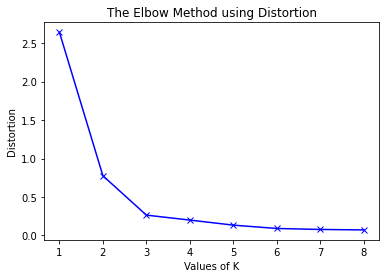

In [ ]:
# Using the different values of Distortion:
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

1 : 328666.0993838686
2 : 41184.07482174503
3 : 8358.25799505887
4 : 4790.645432793832
5 : 3030.797173582362
6 : 1912.7693040388417
7 : 1311.0159873451018
8 : 1024.6512593174227


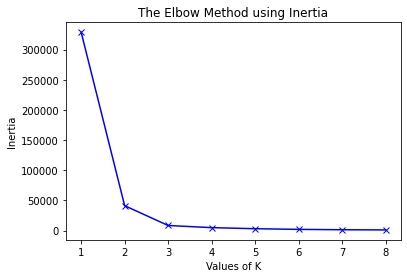

In [ ]:
# Using the different values of Inertia:
for key, val in mapping2.items():
    print(f'{key} : {val}')
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [ ]:
no_of_cluster= 2

In [ ]:
k_means_model=KMeans(n_clusters=no_of_cluster).fit(X)
# k_means_model=KMeans(n_clusters=no_of_cluster,random_state=0).fit(X)

In [ ]:
y_kmeans = list(k_means_model.predict(X))

In [ ]:
print("Number of predictions:",len(k_means_model.labels_))

Number of predictions: 39100


In [ ]:
pca = PCA(n_components=2).fit(X)

In [ ]:
datapoint = pca.transform(X).tolist()

In [ ]:
datapoints = pca.transform(X)

In [ ]:
len(datapoint)

39100

K-clustering


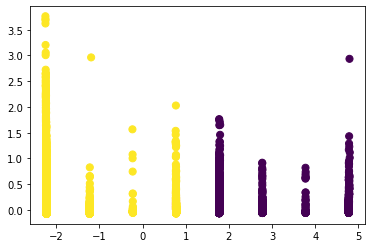

In [ ]:
print("K-clustering")
plt.scatter(datapoints[:, 0], datapoints[:, 1], c=y_kmeans, s=50, cmap='viridis')

True-Flase


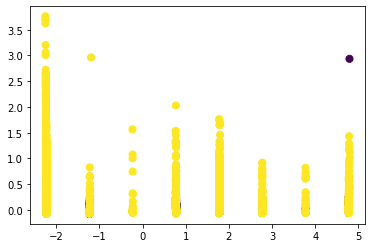

In [ ]:
print("True-Flase")
plt.scatter(datapoints[:, 0], datapoints[:, 1], c=Y, s=50, cmap='viridis')

#Building CAT Boost Model

In [ ]:
X = df[emotion]
y = df.label
X_validation = df_test[emotion]
y_validation = df_test.label

In [ ]:
X

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,highest_eight_label
0,0.370,0.223,0.178,0.094,0.255,0.207,0.000,1.786,trust
1,0.166,0.206,0.000,0.084,0.178,0.144,0.048,0.184,anticipation
2,0.152,0.085,0.043,0.036,0.059,0.108,0.000,1.291,trust
3,0.000,0.741,0.050,0.105,0.268,0.159,0.075,1.438,trust
4,0.157,0.780,0.097,0.071,0.535,0.421,0.054,0.550,anticipation
...,...,...,...,...,...,...,...,...,...
1279,0.267,0.086,0.057,0.102,0.318,0.054,0.060,0.332,trust
1280,0.567,0.087,0.067,0.274,0.243,0.685,0.188,0.091,sadness
1281,0.613,0.028,0.472,0.105,0.058,0.505,0.053,0.386,anger
1282,0.071,0.038,0.000,0.035,0.096,0.016,0.026,0.752,trust


In [ ]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [ ]:
categorical_features_indices

array([8])

In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

# # X_test = test_df

In [ ]:
X_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   anger                1267 non-null   float64
 1   anticipation         1267 non-null   float64
 2   disgust              1267 non-null   float64
 3   fear                 1267 non-null   float64
 4   joy                  1267 non-null   float64
 5   sadness              1267 non-null   float64
 6   surprise             1267 non-null   float64
 7   trust                1267 non-null   float64
 8   highest_eight_label  1267 non-null   object 
dtypes: float64(8), object(1)
memory usage: 89.2+ KB


In [ ]:
X_validation

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,highest_eight_label
0,0.338,1.082,0.038,0.105,0.290,0.092,0.076,0.537,anticipation
1,0.037,0.958,0.000,0.186,0.864,0.000,0.065,0.539,anticipation
2,0.885,0.000,0.448,0.156,0.080,1.107,0.074,0.152,sadness
3,0.425,0.157,0.054,0.204,0.162,0.279,0.010,0.965,trust
4,0.139,0.072,0.025,0.019,0.053,0.073,0.000,1.020,trust
...,...,...,...,...,...,...,...,...,...
1262,0.000,0.113,0.065,0.088,0.822,0.000,0.000,1.757,trust
1263,0.790,0.318,0.000,0.653,2.048,0.046,0.323,0.531,joy
1264,0.271,0.132,0.098,0.290,0.073,0.247,0.000,0.276,fear
1265,0.334,0.161,0.041,0.141,0.194,0.243,0.048,0.545,trust


In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 67.4 MB 27 kB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score

In [ ]:
model = CatBoostClassifier(
    # loss_function = 'MultiClass',
    # 'iterations': 20,
    # learning_rate = 1,
    # depth = 2
    # custom_loss=[metrics.Accuracy()],
    # random_seed=42,
    # logging_level='Silent'
)

In [ ]:
model.fit(
    X, y,
    cat_features=categorical_features_indices,
    # verbose = False
    # eval_set=(X_validation, y_validation),
    # logging_level='Verbose',  # you can uncomment this for text output
    # plot=True
);

Learning rate set to 0.029239
0:	learn: 0.6767599	total: 14.2ms	remaining: 14.2s
1:	learn: 0.6613512	total: 29.9ms	remaining: 14.9s
2:	learn: 0.6470359	total: 44.6ms	remaining: 14.8s
3:	learn: 0.6335490	total: 59.1ms	remaining: 14.7s
4:	learn: 0.6210388	total: 73.9ms	remaining: 14.7s
5:	learn: 0.6093088	total: 88.3ms	remaining: 14.6s
6:	learn: 0.5982783	total: 103ms	remaining: 14.6s
7:	learn: 0.5880086	total: 118ms	remaining: 14.6s
8:	learn: 0.5783454	total: 132ms	remaining: 14.5s
9:	learn: 0.5692554	total: 147ms	remaining: 14.6s
10:	learn: 0.5608591	total: 162ms	remaining: 14.6s
11:	learn: 0.5529523	total: 176ms	remaining: 14.5s
12:	learn: 0.5456043	total: 191ms	remaining: 14.5s
13:	learn: 0.5387051	total: 209ms	remaining: 14.7s
14:	learn: 0.5322579	total: 224ms	remaining: 14.7s
15:	learn: 0.5261265	total: 239ms	remaining: 14.7s
16:	learn: 0.5205554	total: 251ms	remaining: 14.5s
17:	learn: 0.5152210	total: 267ms	remaining: 14.5s
18:	learn: 0.5102771	total: 282ms	remaining: 14.5s
19:	l

In [ ]:
print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, model.predict(X_validation))
))

Simple model validation accuracy: 0.8358


# XG BOOST

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=14), n_estimators=100,algorithm="SAMME.R", learning_rate=0.0001)
ada_clf.fit(X_train[rfecv_features],y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=14),
                   learning_rate=0.0001, n_estimators=100)

In [ ]:
from sklearn import metrics
predicted_y = ada_clf.predict(X_val[rfecv_features])
gg=compute_metrics(predicted_y,y_val)
d=gg
# print(d['accuracy'])
tn, fp, fn, tp = d["confusiton_mat"].ravel()
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp
0.599	0.588	0.563	0.623	0.581	0.605	0.593	169	131	113	187


## Hyperparameter tuning

In [ ]:
!pip install TPOT -q

     |████████████████████████████████| 87 kB 2.7 MB/s 
     |████████████████████████████████| 173.6 MB 8.7 kB/s 
     |████████████████████████████████| 160 kB 54.1 MB/s 


In [ ]:
# from sklearn.ensemble import ExtraTreesClassifier

# model = ExtraTreesClassifier()

from tpot import TPOTClassifier

parameters = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 12],
               'min_samples_split': [5, 10],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}
               
tpot_classifier = TPOTClassifier(generations= 5, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict=
                                 {'sklearn.ensemble.ExtraTreesClassifier': parameters}, 
                                 cv = 4, scoring = 'accuracy')
tpot_classifier.fit(X_train,y_train) 

Optimization Progress:   0%|          | 0/84 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8585029752219795

Generation 2 - Current best internal CV score: 0.8595507448016628

Generation 3 - Current best internal CV score: 0.8603024075722056

Generation 4 - Current best internal CV score: 0.8603024075722056

Generation 5 - Current best internal CV score: 0.8603024075722056

Best pipeline: ExtraTreesClassifier(ExtraTreesClassifier(input_matrix, criterion=gini, max_depth=935, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=850), criterion=gini, max_depth=671, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1200)


TPOTClassifier(config_dict={'sklearn.ensemble.ExtraTreesClassifier': {'criterion': ['entropy',
                                                                                    'gini'],
                                                                      'max_depth': [10,
                                                                                    142,
                                                                                    274,
                                                                                    406,
                                                                                    538,
                                                                                    671,
                                                                                    803,
                                                                                    935,
                                                                                    1067,
           

In [ ]:
# Best pipeline: ExtraTreesClassifier(ExtraTreesClassifier(input_matrix, criterion=gini, max_depth=935, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=850), criterion=gini, max_depth=671, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1200)

In [ ]:
import numpy as np 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier

random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 12],
               'min_samples_split': [5, 10],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

clf = ExtraTreesClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train,y_train) 

Fitting 4 folds for each of 80 candidates, totalling 320 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=4, estimator=ExtraTreesClassifier(), n_iter=80, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 142, 274, 406, 538,
                                                      671, 803, 935, 1067, 1200,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [4, 12],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [151, 267, 384, 500,
                                                         617, 733, 850, 966,
                                                         1083, 1200]},
                   random_state=101, verbose=5)

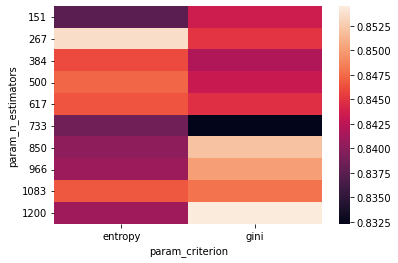

In [ ]:
import seaborn as sns

table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_criterion')
     
sns.heatmap(table)

In [ ]:
from sklearn.metrics import classification_report

predictionforest = model.best_estimator_.predict(X_val)
print(confusion_matrix(y_val,predictionforest))
print(classification_report(y_val,predictionforest))
acc3 = accuracy_score(y_val,predictionforest)

[[9299 1087]
 [1546 6884]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     10386
           1       0.86      0.82      0.84      8430

    accuracy                           0.86     18816
   macro avg       0.86      0.86      0.86     18816
weighted avg       0.86      0.86      0.86     18816



In [ ]:
model.best_estimator_

ExtraTreesClassifier(criterion='entropy', max_depth=935, max_features=None,
                     min_samples_leaf=4, min_samples_split=5, n_estimators=151)

In [ ]:
# AllDF
import numpy as np 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier

random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 12],
               'min_samples_split': [5, 10],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

clf = ExtraTreesClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train,y_train) 


Fitting 4 folds for each of 80 candidates, totalling 320 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
import seaborn as sns

table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_criterion')
     
sns.heatmap(table)

In [ ]:
from sklearn.metrics import classification_report

predictionforest = model.best_estimator_.predict(X_val)
print(confusion_matrix(y_val,predictionforest))
print(classification_report(y_val,predictionforest))
acc3 = accuracy_score(y_val,predictionforest)

In [ ]:
model.best_estimator_